# Predicting eye movements using logistic regression

In this project, we will conduct model comparison and feature selection to assess what influences where a monkey will next look.

We use a task where four images are displayed on a screen (one in each corner), each of which signals a certain value of reward you can gain from collecting them. Data is taken from when the monkey first looks at one of the four images. Hence the other three images are only visible in peripheral vision, one image of which is closer and the other two are further away (due to the rectangular screen).

![image](task.png)

We want to see whether we can predict which image the monkey will look at second using the value of the different images on the screen. Do you think the monkey will be able to use his peripheral vision to determine the value of the other cues on the screen to enable him to efficiently look at higher value images before lower value ones? Let's find out...

#### Data import and exploration

First, we load the data and our required modules. The data consist of the y data we are trying to predict (whether the monkey will look at the nearby cue or either of the far cues next) and the x data we will use to try and predict y (the value of the cue looked at, the nearby cue, and the two far cues). We have data from 20 different sessions which we will iterate through to use as independent measures of the analyses we perform.

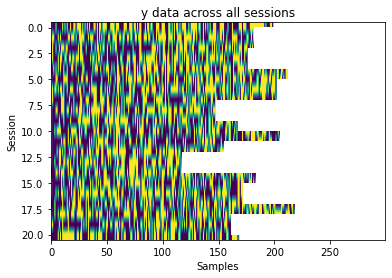

In [1]:
import numpy as np
import scipy
import plot  # Custom plot function for this script
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
import statsmodels.api as sm
import warnings; warnings.filterwarnings('ignore') 

# Load in data
x = np.load('x.npy')  # The value of each of the four images [numSessions x numFeatures x numSamples]
y = np.load('y.npy')  # Whether he looks at a near or far cue next [numFeatures x numSamples]

# X features are in the following order
labels = 'Cue looked at', 'Neighbouring cue', 'Far cue #1', 'Far cue #2'

numSessions = x.shape[0]

# Let's inspect our data quickly
plt.imshow(y, aspect='auto',interpolation=None); plt.ylabel('Session'); 
plt.xlabel('Samples'); plt.title('y data across all sessions');

We can see that the monkey completed a different number of samples in each session, so we'll have to be careful to handle the trailing NaNs (white values) in our data.  

### Logistic regression and cross-validation

Now lets build our model. Our dependent variable is binary (look at near or far cue), hence we'll use logistic regression to  predict it. Our independent variables are the value of each of the four cues on the screen. We will use five-fold cross-validation to examine the accuracy of the model. This will be repeated over each session, which are independent samples. 

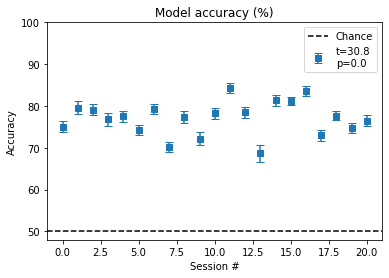

In [2]:
logReg = LogisticRegression()

#% We use stratified sampling to ensure an even distribution of labels in our test set
SplitGenerator = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

scoresFull = np.empty((numSessions, 50))  # Holding array

for iSess, (xx, yy) in enumerate(zip(x, y)):  # For each session
    
    # We have to remove the trailing NaNs from our jagged arrays
    xx, yy = xx.T[~np.isnan(yy)], yy[~np.isnan(yy)]
    
    # Cross-validate this session's data
    scoresFull[iSess] = cross_val_score(logReg, xx, yy, cv=SplitGenerator) * 100

# First average within each session, as these are not independent measures
avgScores = np.mean(scoresFull, axis=1)  

# Now compute stats across our independent measure (each session)
avg = np.mean(scoresFull,axis=1)
sem = np.std(scoresFull,axis=1)/np.sqrt(numSessions)
t, p = scipy.stats.ttest_1samp(avgScores, 50)

plot.plot1(avg, sem, t, p);

Cool, we can see our model already works well, with its accuracy, t-statistic and p-value all well above chance levels. Therefore, it is possible to predict where the monkey will look from the value of the cues on the screen!

## Hyperparameter tuning
Logistic regression doesn't typically need much tuning, nonetheless we'll do our due diligence to ensure we have the best possible model for our data.

sklearn has five different ways of calculating the logistic regression algorithm. We'll use the GridSearchCV function to find each solver's best hyperparameters, then compare between solvers using paired t-tests across our sessions. 

Pairwise p-values
 [[   nan 0.6012 0.4512 0.1517 0.9776]
 [0.6012    nan 0.723  0.2355 0.6388]
 [0.4512 0.723     nan 0.5161 0.4761]
 [0.1517 0.2355 0.5161    nan 0.1117]
 [0.9776 0.6388 0.4761 0.1117    nan]]


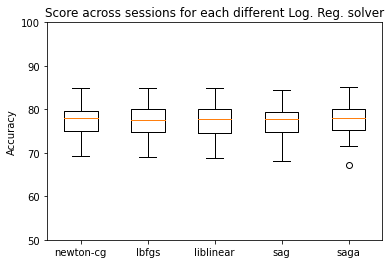

In [3]:
# Define our storage array and the hyperparameters to search over
bestScores, bestParams = np.empty((5, numSessions)), np.empty((5, numSessions, 3), dtype=object)
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalties = [['l2', 'none'], ['l2', 'none'], ['l1', 'l2'], ['l2', 'none'],['elasticnet', 'l1', 'l2', 'none']]
c_values = [100, 10, 1.0, 0.1, 0.01]

for  iSolve, (solver,penalty) in enumerate(zip(solvers, penalties)):  # For each solver
    
    # Create grid search
    grid = dict(solver=[solver],penalty=penalty,C=c_values)
    grid_search = GridSearchCV(estimator=logReg, param_grid=grid, cv=SplitGenerator, scoring='accuracy');
    
    for iSess, (xx, yy) in enumerate(zip(x, y)):  # For each session
        
        # We have to remove the trailing NaNs from our jagged data
        xx, yy = xx.T[~np.isnan(yy)], yy[~np.isnan(yy)]
         
        # Perform grid search and log the results
        grid_result = grid_search.fit(xx, yy);
        bestScores[iSolve,iSess] = grid_result.best_score_ * 100
        bestParams[iSolve, iSess] = list(grid_result.best_params_.values())
    
#%% Pairwise stats between each solver
ts, ps = np.ones((len(solvers), len(solvers))), np.ones((len(solvers), len(solvers)))
for i in range(len(solvers)):
    for j in range(len(solvers)):
        ts[i, j],ps[i,j] = scipy.stats.ttest_rel(bestScores[i],bestScores[j])
print('Pairwise p-values\n', np.round(ps, 4))

plot.plot2(bestScores, solvers);

All our solvers resulted in similar model accuracies, and there were no significant differences in accuracy between the solvers. This is likely due  to it being quite a small dataset (4 features x 150-250 samples). We'll still go ahead and use the best hyperparameters anyway. 

In [4]:
# Use indexing to find the best hyperparameters
iBestSolver = np.argmax(np.mean(bestScores,axis=1))
iBestPenalty= np.argmax([np.sum(bestParams[iBestSolver, :, 1]==p) for p in penalties[iBestSolver]])
iBestC= np.argmax([np.sum(bestParams[iBestSolver, :, 0]==c) for c in c_values])

# Set hyperparameters in model
solver, penalty, c =solvers[iBestSolver], penalties[iBestSolver][iBestPenalty], c_values[iBestC]
logReg = LogisticRegression(solver=solver, penalty=penalty, C=c)

## Feature  selection

Now that we're happy with our model, it is time to test whether all four of our features are actually contributing to the model's predictions (i.e. is the monkey using all four cues to decide where to look). First, lets examine each parameter's coefficients across sessions. If a parameter is not used by the model then it's coefficients should be centered around zero. Thus, we will use 1-sample t-test against 0 to statistically test our hypothesis.

We'll arrange the data such that below zero on the y-axis means predicting an eye movement towards the far cues, and above zero values mean towards the near cue.

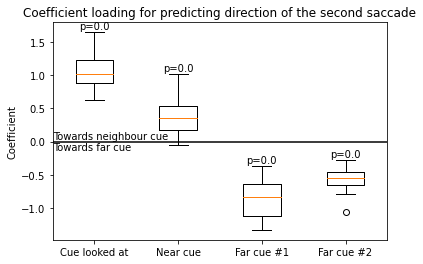

In [5]:
coeffs = np.empty((numSessions, 4))  # Holding array

for iSess, (xx, yy) in enumerate(zip(x, y)):  # For each session
    
    # We have to remove the trailing NaNs from our jagged arrays
    xx, yy = xx.T[~np.isnan(yy)], yy[~np.isnan(yy)]

    # Get coefficients of model using all available data
    coeffs[iSess] = logReg.fit(xx, yy).coef_

# Stats
ts, ps = scipy.stats.ttest_1samp(coeffs, 0)

plot.plot3(coeffs, ps)

Cool, we can see that all four parameters are far away from 0, meaning they were likely all informatitive to our model's predictions. 

The direction of them also makes sense, an increase in the value of the near two cues made the monkey more likely to keep looking in that area, whereas an increase in the value of the far two cues made the monkey more likely to look towards the far area. 

#### Parameter removal
Now we'll try removing each parameter individually and see how it affects the model's accuracy. To statistically test this, we'll compute the difference between the full and each reduced model, and then assess the resulting differences using a t-test against 0.

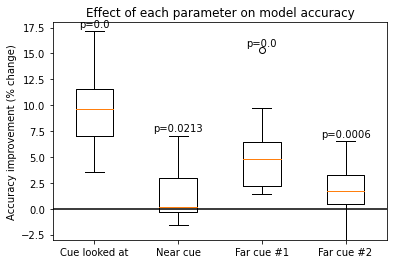

In [6]:
scoresReduc = np.empty((4, numSessions, 50))  # Holding array

for iSess, (xx, yy) in enumerate(zip(x, y)):  # For each session
    
    # We have to remove the trailing NaNs from our jagged arrays
    xx, yy = xx.T[~np.isnan(yy)], yy[~np.isnan(yy)]

    for iCoeff in range(4):
        
        #Accuracy of the model with feature removed
        xxx = np.delete(xx, iCoeff, axis=1)
        scoresReduc[iCoeff, iSess] = cross_val_score(logReg, xxx, yy, cv=SplitGenerator) * 100

#% Stats
avgScoresReduc = np.mean(scoresReduc, axis=2)
scoresReducNorm = avgScores - avgScoresReduc
ts, ps = scipy.stats.ttest_1samp(scoresReducNorm.T, 0)

plot.plot4(scoresReducNorm, ps);

Great, in agreement with our previous analysis, each parameter had a significant effect on the model's performance (although if we correct for repeated measures the near cue would no longer be significant).

#### Pseudo Rsquared
Examining coefficient's is not an ideal measure of each feature's importance, however, as it is sensitive to the variance of the feature. The R-squared is a better measure of our model's performance that is insensitive to differences between features. As this is logistic regression which uses likelihood estimation (rather than least squares fitting of linear regression), we need to approximate it using a pseudo Rsquared measure. The statsmodel's logistic regression function has a built-in one which we'll use to calculate the effect of removing each of our features from the model.

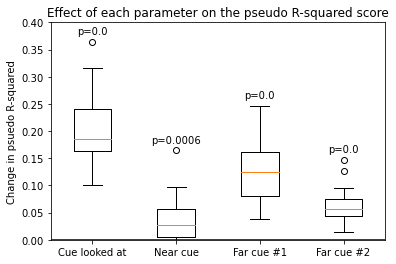

In [7]:
pseudoR = np.empty((5, numSessions))  # Holding array
for iSess, (xx, yy) in enumerate(zip(x, y)):  # For each session
    
    # We have to remove the trailing NaNs from our jagged arrays
    xx, yy = xx.T[~np.isnan(yy)], yy[~np.isnan(yy)]
    
    # SM doesnt add intercept by default
    xx = np.vstack((xx.T, np.ones(len(xx)))).T
    
    # Fit full model and get rSquared
    full = sm.Logit(yy, xx).fit(disp=0)
    pseudoR[0, iSess] = full.prsquared
    
    for iCoeff in range(4):
        
        # Remove coefficient
        xxx = np.delete(xx, iCoeff, axis=1)

        # Fit reduced model and log rSquared
        red = sm.Logit(yy, xxx).fit(disp=0)
        pseudoR[iCoeff+1, iSess] =  red.prsquared

# Stats
pseudoRsqrNorm = pseudoR[0]  - pseudoR[1:]  # Subtract full model score
ts, ps = scipy.stats.ttest_1samp(pseudoRsqrNorm.T, 0)  # T-test of differences against 0

# Plot
plot.plot5(pseudoRsqrNorm, ps);

Cool, there was again a strongly significant effect of each of our features on the model's pseudo Rsquared value. 

#### BIC/AIC scores
Due to the Bias-Variance tradeoff, however, adding an extra parameter also increases the variance of our model, making it more prone to overfitting. Hence, we need to check that the increase in performance that each parameter grants outweighs the resulting increase in variance that it causes.  

To check for this we can use BIC and AIC scores, which rate a model's performance while simultaneously penalising it for its complexity (with BIC also taking into account the number of samples). Hence, they indicate whether we are justified in including an extra parameter in a model.

Again, we will compute the difference in AIC/BIC between the full and reduced models, and use t-test's to check whether the full model's score is significantly better than that of the reduced models. I will plot the data such that high values represent a better model (even though low BIC/AIC scores are better).  

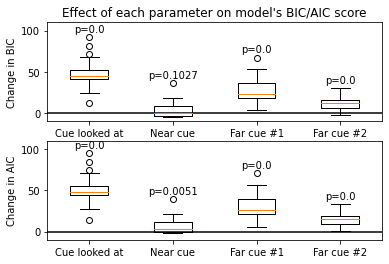

In [8]:
bics, aics = np.empty((5, numSessions)), np.empty((5, numSessions))
for iSess, (xx, yy) in enumerate(zip(x, y)):  # For each session
    
    # We have to remove the trailing NaNs from our jagged arrays
    xx, yy = xx.T[~np.isnan(yy)], yy[~np.isnan(yy)]
    
    # SM doesnt add intercept by default
    xx = np.vstack((xx.T, np.ones(len(xx)))).T
    
    # Fit full model and get BIC
    full = sm.Logit(yy, xx).fit(disp=0)
    bics[0, iSess] = full.bic
    aics[0, iSess] = full.aic
    
    for iCoeff in range(4):
        
        # Remove coefficient
        xxx = np.delete(xx, iCoeff, axis=1)

        # Fit reduced model and log BIC
        red = sm.Logit(yy, xxx).fit(disp=0)
        bics[iCoeff+1, iSess] =  red.bic
        aics[iCoeff+1, iSess] =  red.aic

plot.plot6(bics,aics);

Cool, we can see that in all cases (with the exception of the near cue's BIC score), we had a strongly significant effect on the model's score when we included each parameter. 

Therefore, it is clear that the direction of the eye movement was influenced by the value of all four objects on the screen, even though three of the cues hadn't even been looked at and were only in the peripheral vision. That is some impressive parallel processing of peripheral objects! You can read a much more detailed description of this cool ability, and the neural activity that gives rise to it, in my [paper](https://www.biorxiv.org/content/10.1101/2021.10.08.463476v1).